# Skin Cancer Detection 
This objective o this notebook is to take [This kaggle dataset](https://www.kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai)

Much of the pre-processing inspiration comes from:

https://www.kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai 

to train a state of the art image classification model to detect skin cancer. 

This is **part 1** of several notebooks and scripts for a much larger open source project. 

The aim of this project is to: 
* Build a state of the art model for skin cancer
* Deploy that model onto an iOS device for anyone to use
* Document everything for anyone to create the same

My wish from this project is truly to educate and inpsire others. Thus we will cover everything from:
* downloading the data
* data augmentation 
* building a model
* evaluating & fine-tuning (based on state of the art)
* converting our model to CoreML 
* designing & creating a simple iOS app that uses our state of the art model 

### Installing libraries
Quickly installing all libraries we will use from downloading our data, exploring our data, building our model. 

We will be using **fastai's v1.0 framework** to build our model. 

I HIGHLY suggest checking them out. Not only do they provide such an amazing framework (sitting on top of Pytorch 1.0) but also provide *free* online courses, teaching you how to build state of the art models 

Check them out here:
[www.fast.ai](www.fast.ai)

In [ ]:
# libraries
!pip install fastai
!pip install kaggle --upgrade

In [ ]:
# Importing
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import torch

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import os
import json

In [ ]:
# checking if enabled
torch.backends.cudnn.enabled == True

True

In [ ]:
# configuring kaggle
!mkdir .kaggle # we will store in this directory

cred = json.dumps({"username":"dmbernaal","key":"8b35c9b4aaeb3511fd8837d7b08bca19"}) # change with your credentials
with open('.kaggle/kaggle.json', 'w') as f:
  f.write(cred) # writes to the .kaggle folder
  
# Configuring the file - we will run this twice (second time next block)
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# run for second time
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
# making private
!chmod 600 /root/.kaggle/kaggle.json

### Downloading our data

In [ ]:
# Creating directories and paths
!mkdir data
!mkdir data/images # will contain all raw images

path = '/content/data'
images_path = '/content/data/images'

In [ ]:
# downloading our data
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p {path}

100% 2.61G/2.62G [00:26<00:00, 84.6MB/s]
100% 2.62G/2.62G [00:27<00:00, 104MB/s] 


In [ ]:
# Unzipping files and deleting zipped files
!unzip -q -n {path}/skin-cancer-mnist-ham10000.zip -d {path} 

!unzip -q -n {path}/HAM10000_images_part_1.zip -d {images_path}
!unzip -q -n {path}/HAM10000_images_part_2.zip -d {images_path}

In [ ]:
!ls data/images | head

ISIC_0024306.jpg
ISIC_0024307.jpg
ISIC_0024308.jpg
ISIC_0024309.jpg
ISIC_0024310.jpg
ISIC_0024311.jpg
ISIC_0024312.jpg
ISIC_0024313.jpg
ISIC_0024314.jpg
ISIC_0024315.jpg


### Data Exploration & Analysis

In [ ]:
# setting paths
path = '/content/data'
images_path = '/content/data/images'
csv_path = '/content/data/HAM10000_metadata.csv' # contains all labels & more

In [ ]:
# creating pandas dataframe - with image id as index
df = pd.read_csv(csv_path).set_index('image_id')
df.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, ISIC_0027419 to ISIC_0032258
Data columns (total 6 columns):
lesion_id       10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(5)
memory usage: 547.7+ KB


In [ ]:
# Creating dictionary with lession categories (classes)
lession_dict = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}


In [ ]:
# Let's now form categories from dx columns and create a labels & lesion column
df['dx'] = df['dx'].astype('category', copy=True) # turning into category type

df['labels'] = df['dx'].cat.codes # converts each to a numerical code
df['lesion'] = df['dx'].map(lession_dict)

In [ ]:
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign


In [ ]:
# taking a look at all lesions and their count
df.lesion.value_counts()

Benign       7919
Malignant    1627
Drop          469
Name: lesion, dtype: int64

### Creating Dataset

In [ ]:
# Creating a custom image list class
class CustomImageItemList(ImageItemList):
  
    def custom_label(self,df, **kwargs)->'LabelList':
      
        """Custom Labels from path"""
        
        file_names=np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels=lambda x: df.loc[x,'lesion']
        
        #self.items is an np array of PosixPath objects with each image path
        labels= get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self,y=y)
        
        return res

In [ ]:
# Creating function to get our data in a format fastai likes
"""
    We will be calling this function multiple times to get better accuracy
"""

# Transforms - we will later play around with these
do_flip = True
flip_vert = True
max_rotate = 10.0
max_zoom = 1.01 # not default, but will start smaller

# Creating out get_data function, which will return a data object for us
def get_data(bs, size):
    train_ds = (CustomImageItemList.from_folder(path, extensions='.jpg')
                    .random_split_by_pct(0.15)
                    .custom_label(df)
                    .transform(tfms=get_transforms(do_flip=do_flip, flip_vert=flip_vert, max_rotate=max_rotate, max_zoom=max_zoom),size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

### Building our Model
Inititally we will test various arch with few epoch

Then we will pick one and:
* Fine tune (wd, lr, etc)

Once we have a fine-tuned model we will apply some further fine tuning tricks such as:
* increasing image size per run 

We will later train this model on the cloud (GCP) with much more compute on a much larger model. 

In [ ]:
# We will experiment with these two models
arch_resnet50 = models.resnet50

In [ ]:
# Tuning parameters
weight_decay_active = True # will turn on/off
batch_norm_weight_decay = False # turns on/off weight decay is removed from batchnorm

image_size = 224 # change this per turn
batch_size = 100

momentum_values_default = (0.99, 0.90) # we will set when calling learn.fit_one_cycle
momentum_values_two = (0.95, 0.85) # default

dropout_default = 0.5
dropout_1 = 0.2

In [ ]:
# Creating data object
data = get_data(batch_size, image_size)

In [ ]:
data.classes

['Benign', 'Drop', 'Malignant']

In [ ]:
"""
ResNet50 settings
"""
# Creating our learner - pretrained model
learn = create_cnn(data, arch_resnet50, metrics=[error_rate, accuracy], ps=dropout_1)

# setting a few hyperparameters
learn.true_wd = weight_decay_active
learn.bn_wd = batch_norm_weight_decay

### Training & Fine-tuning model

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


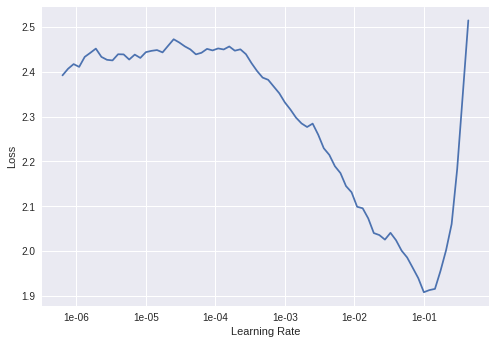

In [ ]:
# finding optimal learning late
learn.lr_find()
learn.recorder.plot()

In [ ]:
"""
ResNet50 Lrs
"""
# picking optimal learning rate
lr1 = 0.25
lr2 = 0.1
lr3 = 0.07
lr4 = 0.06
lr5 = 0.085
lr6 = 0.075

In [ ]:
"""
ResNet50
weight decay: 1e-2
momentum range: (0.95, 0.85)
learning rate: 0.06
batch size: 100
dropout: 0.2
"""
# learn.fit_one_cycle(20, slice(lr), moms=momentum_values_two, wd=weight_decay)
learn.fit_one_cycle(10, max_lr=lr4, pct_start=0.3, moms=momentum_values_two, wd=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.769208,0.992097,0.309587,0.690413
2,0.712906,0.701670,0.254328,0.745672
3,0.719209,1.007095,0.306924,0.693076
4,0.712762,2.419852,0.376165,0.623835
5,0.661298,0.629573,0.225033,0.774967
6,0.594375,0.607708,0.207723,0.792277
7,0.556535,0.828372,0.211718,0.788282
8,0.512304,0.500756,0.178429,0.821571
9,0.437637,0.423070,0.158455,0.841545
10,0.396703,0.407583,0.142477,0.857523


In [ ]:
# saving the model
learn.save('stage-1-224-resnet50')

In [ ]:
learn.load('stage-1-224-resnet50')

In [ ]:
# unfreezing all layers, we will apply differential learning rates
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


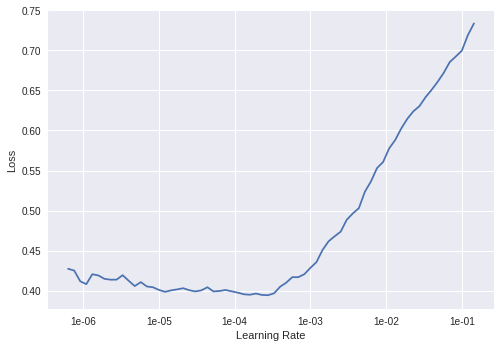

In [ ]:
# let's find the optimal learning rates
learn.lr_find()
learn.recorder.plot()

In [ ]:
# picking optimal learning rates
lr1 = 0.000001 # min
lr2 = 0.00001
lr3 = 0.00045 # max

In [ ]:
# 2nd round of training
learn.fit_one_cycle(10, max_lr=(lr1, lr2, lr3), moms=momentum_values_two, wd=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.392632,0.406837,0.141811,0.858189
2,0.380427,0.405447,0.144474,0.855526
3,0.381559,0.409194,0.141145,0.858855
4,0.376549,0.400097,0.145140,0.854860
5,0.373565,0.397950,0.139814,0.860186
6,0.365007,0.394138,0.139148,0.860852
7,0.354953,0.392103,0.135819,0.864181
8,0.354809,0.393962,0.138482,0.861518
9,0.345960,0.391245,0.136485,0.863515
10,0.345774,0.391053,0.135819,0.864181


In [ ]:
learn.save('stage-2-224-resnet50-A')

In [ ]:
learn.load('stage-2-224-resnet50-A')

In [ ]:
# Creating a new data object to resize

size = 299 # 299x299
data = get_data(batch_size, image_size)

learn.data = data

In [ ]:
# Let's not freeze all the layers
learn.freeze()

epoch,train_loss,valid_loss,error_rate,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


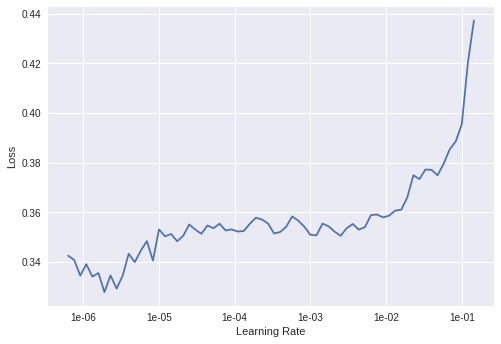

In [ ]:
# finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# picking optimal learning rate
lr = 0.005

In [ ]:
# now we most do a grid search for weight decay
"""
ResNet50
weight decay: 1e-6 
momentum range: (0.95, 0.85)
learning rate: 0.06
batch size: 128
dropout: 0.2
"""

momentum_values = (0.99, 0.90) # we will set when calling learn.fit_one_cycle
momentum_values_two = (0.95, 0.85) # default


learn.fit_one_cycle(10, slice(lr), wd=1e-2)
# learn.fit_one_cycle(5, slice(lr), moms=momentum_values)
# learn.fit(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.372777,0.334436,0.107856,0.892144
2,0.368966,0.292991,0.110519,0.889481
3,0.378377,0.303887,0.114514,0.885486
4,0.367816,0.291045,0.109188,0.890812
5,0.354128,0.295160,0.110519,0.889481
6,0.357410,0.287012,0.101198,0.898802
7,0.355644,0.289361,0.107856,0.892144
8,0.344997,0.282938,0.105859,0.894141
9,0.341824,0.281348,0.105859,0.894141
10,0.344808,0.282048,0.107190,0.892810


In [ ]:
learn.save('stage-1-299-resnet50')